In [1]:
import pandas as pd
import numpy as np
import mysql.connector as sql
import diffprivlib
import diffprivlib.tools as tools
from diffprivlib.models import GaussianNB
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB as sklearn_GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# set up mysql connector
c = sql.connect(host='localhost', database='adventureworks',
                              user='root', password='PASSWORD')

## Employee Data - Masking personal information using histogram

We demonstrate a feature of Diffprivlib that creates a privatized histogram using the `GeometricTruncated` mechanism. We used employee data to demonstrate the idea that for a continuous variable (age in our example), the distribution of the original data is similar to the "masked" (noisy) data. In addition, the descriptive statistics including mean and standard deviation are also maintained when noise is added.

In [3]:
# retrieve employee data from adventureworks database
employee = pd.read_sql(""" SELECT C.FirstName,
                                                                   C.MiddleName,
                                                                   C.LastName,
                                                                   C.Suffix,
                                                                   C.EmailAddress,
                                                                   C.Phone,
                                                                   E.title,
                                                                   E.BirthDate,
                                                                   E.MaritalStatus,
                                                                   E.Gender,
                                                                   E.HireDate,
                                                                   E.VacationHours,
                                                                   E.SickLeaveHours
                                                    FROM   employee AS E
                                                    JOIN   employeeaddress AS EA
                                                    USING  (EmployeeID)
                                                    JOIN   address AS A
                                                    USING  (AddressID)
                                                    JOIN   stateprovince AS SP
                                                    USING  (StateProvinceID)
                                                    JOIN   countryregion AS CR
                                                    USING  (CountryRegionCode)
                                                    JOIN   contact AS C
                                                    USING  (ContactID)
                                                    JOIN   employeepayhistory AS EPH
                                                    USING  (EmployeeID)
                                                    """, c)

# create age and tenure column 
employee['Now'] = np.datetime64('2020-12-31')
employee['Age'] = (employee['Now'] - employee['BirthDate']).dt.days / 365
employee['Tenure'] = (employee['Now'] - employee['HireDate']).dt.days / 365

# preview data
employee.head(3)

,FirstName,MiddleName,LastName,Suffix,EmailAddress,Phone,title,BirthDate,MaritalStatus,Gender,HireDate,VacationHours,SickLeaveHours,Now,Age,Tenure
0,Guy,R,Gilbert,None,guy1@adventure-works.com,320-555-0195,Production Technician - WC60,1972-05-15,M,M,1996-07-31,21,30,2020-12-31,48.663014,24.435616
1,Kevin,F,Brown,None,kevin0@adventure-works.com,150-555-0189,Marketing Assistant,1977-06-03,S,M,1997-02-26,42,41,2020-12-31,43.608219,23.860274
2,Roberto,None,Tamburello,None,roberto0@adventure-works.com,212-555-0187,Engineering Manager,1964-12-13,M,M,1997-12-12,2,21,2020-12-31,56.087671,23.068493


### Using regular histogram

mean: 52.29810993584186
std: 8.953329604978297


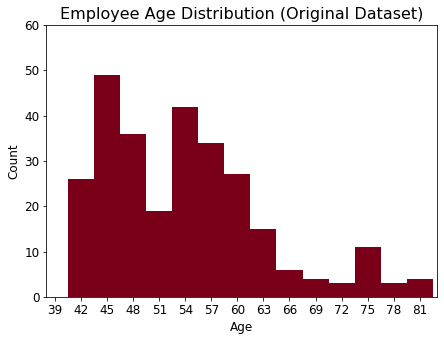

In [4]:
# calculate descriptive statistics
age = employee.Age.value_counts().reset_index()[['index', 'Age']]
age.rename(columns={'index': 'age', 'Age':'count'}, inplace=True)
age.sort_values(by='age', inplace=True)
print("mean:", employee.Age.mean())
print("std:", employee.Age.std())


# plot age distribution
original=plt.figure(figsize=(7, 5))
plt.hist(age['age'], bins=list(range(39, 82, 3)), align='right', color='#7a0019')
plt.title("Employee Age Distribution (Original Dataset)", size=16)
plt.xlabel("Age", size=12)
plt.ylabel("Count", size=12)
plt.xticks(list(range(39, 82, 3)), size=12)
plt.yticks(size=12)
plt.xlim(38, 83)
plt.ylim(0, 60)
plt.show()

# original.savefig('original.png', transparent=True)

### Using diffprivlib's histogram

mean: 52.43166502245689
std: 9.072349433270965


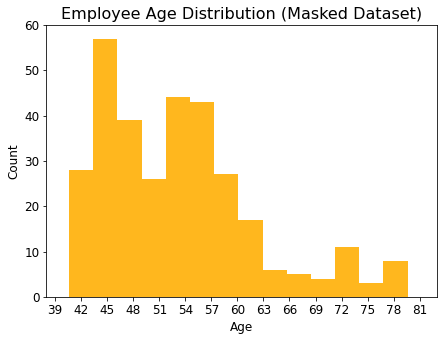

In [5]:
# set random seed and create masked dataset
np.random.seed(10)
tools_hist = tools.histogram(np.array(employee.Age), range=(39, 82), bins= list(range(39, 82, 3)))


# calculate descriptive statistics using diffprivlib
print("mean:", tools.mean(np.array(employee.Age), bounds=(39, 82)))
print("std:", tools.std(np.array(employee.Age), bounds=(39, 82)))


# plot histogram using diffprivlib
masked=plt.figure(figsize=(7, 5))
plt.hist(tools_hist[1][1:], len(tools_hist[0]), weights=tools_hist[0], align='left', color='#ffb71e')
plt.title("Employee Age Distribution (Masked Dataset)", size=16)
plt.xlabel("Age", size=12)
plt.ylabel("Count", size=12)
plt.xticks(list(range(39, 82, 3)), size=12)
plt.yticks(size=12)
plt.xlim(38, 83)
plt.ylim(0, 60)
plt.show()

# masked.savefig('masked.png', transparent=True)

-----------------------------------------

## Customer Behaviour Classifier

In addition to simple histogram, diffprivlib also provides advanced analytics modeling mechanisms. In this example, we leveraged the customer data in the adventureworks database and tried to identify what kind of customer tends to buy products with a higher unit price (in our example - 2000 dollars) using diffprivlib's GaussianNB() model.

As shown in the result below, the two iterations have comparable accuracy measures, indicating the effecitiveness of diffprivlib. However, since the label is changed randomly, the precision recall scores of diffprivlib's GaussianNB model are relatively limited. This indicates that diffprivlib may be more effective in scenarios where false negative or false positive are equally weighted.

In [6]:
# retrieve customer data from adventureworks database
customer = pd.read_sql("""  SELECT CU.AccountNumber,
                                                                   C.Title,
                                                                   C.FirstName,
                                                                   C.MiddleName,
                                                                   C.LastName,
                                                                   C.Suffix,
                                                                   C.EmailAddress,
                                                                   C.Phone,
                                                                   AT.Name AS AddressType,
                                                                   A.AddressLine1,
                                                                   A.AddressLine2,
                                                                   A.City,
                                                                   SP.Name AS StateProviceName,
                                                                   CR.Name AS CountryRegionName,
                                                                   A.PostalCode,
                                                                   CC.CardType,
                                                                   CC.CardNumber,
                                                                   CC.ExpMonth,
                                                                   CC.ExpYear,
                                                                   round(sales.sales_total,2) AS total,
                                                                   CASE WHEN CU.CustomerID IN (SELECT DISTINCT CustomerID
                                                                                                                                FROM   salesorderdetail AS SD
                                                                                                                                JOIN   salesorderheader AS SH
                                                                                                                                USING  (SalesOrderID)
                                                                                                                                WHERE UnitPrice > 2000) THEN 1
                                                                              ELSE 0
                                                                   END AS label
                                                    FROM   adventureworks.customer AS CU
                                                    JOIN   customeraddress AS AD
                                                    USING  (CustomerID)
                                                    JOIN   address AS A
                                                    USING  (AddressID) 
                                                    JOIN   addresstype AS AT
                                                    USING  (AddressTypeID)
                                                    JOIN   stateprovince AS SP
                                                    USING  (StateProvinceID)
                                                    JOIN   countryregion AS CR
                                                    USING  (CountryRegionCode)
                                                    JOIN   individual AS I
                                                    USING  (CustomerID) 
                                                    JOIN   contactcreditcard AS CCC
                                                    USING  (ContactID)
                                                    JOIN   creditcard AS CC
                                                    USING  (CreditCardID)
                                                    JOIN   contact AS C
                                                    USING  (ContactID)
                                                    LEFT JOIN (SELECT  CustomerID,
                                                                                         SUM(LineTotal) AS sales_total
                                                                         FROM   salesorderdetail AS SD
                                                                         JOIN   salesorderheader AS SH
                                                                         USING  (SalesOrderID)
                                                                         GROUP BY CustomerID) AS sales
                                                    USING  (CustomerID);
                                                    """, c)


# change NULL value in SQL to NaN in python
customer = customer.fillna(value=np.nan)


# feature engineering: select a few meaningful features and make it binary format
customer = customer[['AddressType', 'City', 'StateProviceName', 'CountryRegionName',
                                           'PostalCode', 'CardType', 'total', 'label']]
data = pd.get_dummies(customer)


# preview data
data.head(3)

,total,label,AddressType_Home,AddressType_Shipping,City_Ballard,City_Baltimore,City_Barstow,City_Basingstoke Hants,City_Baytown,City_Beaverton,...,PostalCode_WA1 4SY,PostalCode_WA3,PostalCode_WA3 7BH,PostalCode_Y024 1GF,PostalCode_Y03 4TN,PostalCode_YO15,CardType_ColonialVoice,CardType_Distinguish,CardType_SuperiorCard,CardType_Vista
0,8248.99,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,6383.88,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,8114.04,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Regular Classifier: Using scikit learn's GaussianNB

In [7]:
# build GaussianNB() model using scikit learn package
X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis=1), data['label'], test_size=0.25, random_state=0)
classifier = sklearn_GaussianNB().fit(X_train, y_train)
prediction = classifier.predict(X_test)

print("AUC:", roc_auc_score(y_test, prediction), '\n')
print (classification_report(y_test, prediction, digits=4))

AUC: 0.7235919520774508 

              precision    recall  f1-score   support

           0     0.8686    0.6863    0.7668      3226
           1     0.5130    0.7609    0.6128      1401

    accuracy                         0.7089      4627
   macro avg     0.6908    0.7236    0.6898      4627
weighted avg     0.7609    0.7089    0.7201      4627



### Using diffprivlib's GaussianNB model

In [8]:
# set another random seed
np.random.seed(19)

# build another classifier using diffprivlib's GaussianNB() model
clf = GaussianNB()
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)

print("AUC:", roc_auc_score(y_test, prediction), '\n')
print (classification_report(y_test, prediction, digits=4))

C:\Users\User\anaconda3\lib\site-packages\diffprivlib\models\naive_bayes.py:102: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  "privacy leakage, specify bounds for each dimension.", PrivacyLeakWarning)


AUC: 0.500342616844845 

              precision    recall  f1-score   support

           0     0.6974    0.9978    0.8210      3226
           1     0.3636    0.0029    0.0057      1401

    accuracy                         0.6966      4627
   macro avg     0.5305    0.5003    0.4133      4627
weighted avg     0.5963    0.6966    0.5741      4627



## Summary

The `Mechanisms` submodule provides other "masking" algorithms. For example, the histogram uses GeometricTruncated mechanism, but diffprivlib also provides other mechanisms that you could "mask your data in different ways". With limited time we will not demonstrate this feature, but we want to mention that there is more than one options available to mask the data.